# Домашнее задание 1

Данное домашнее задание построено по семинарам 1-3.

Каждое домашнее задание состоит из 2 частей $-$ основная часть предназначена для **всех**, а задания, помеченные звездочками, для ребят, которые хотят также делать **усложненные** задания. Как следствие, и нормировка для вас будет разная.

Те, кто участвует в проектах в рамках курса "Стохастический анализ в задачах" должны выполнять **все** задания!

Домашние задания составляют 100% от вашей оценки за курс.

Домашние задания отправляются на почту OptimizationHomework@yandex.ru

Тема -- **МФТИ-Сава-{номер домашки}**

Файл должен называться **Фамилия_Имя**

Неправильное отправление дз карается (к сожалению) 0 баллами за д/з, так как попросту будет невозможно найти его.

Если найдете существенную ошибку в формулировках и коде - 0.1 к итоговой оценке.

Дедлайн этого домашнего задания -- 16 марта 23:59. Дедлайн жесткий.

In [1]:
import numpy as np

# Градиентный спуск.

Рассмотрим следуюущую задачу оптимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} \left[f(x) := \tfrac{1}{2} x^T A x - b^T x\right],
\end{equation}
где $A \in \mathbb{R}^{d \times d}$, $b \in \mathbb{R}^d$.

__(а)__ Является ли данная задача всегда выпуклой/сильной выпуклой? При каких условиях?

Также придумайте (или найдите) способ генерации матрицы $А$, так чтобы $f$ была сильно выпуклой, а также можно было задавать и менять $d, \mu, L$ (вариант с диагоналоной матрицей оценивается в невыполненный пункт).

Ответ: Рассмотрим градиент $\nabla f(x) = \frac{1}{2}\langle A^T + A, x \rangle - b$, и гессиан $\nabla^2 f = \frac{1}{2}(A + A^T)$ тогда по критерию выпуклости необходимо и достаточно, чтобы матрица $(A + A^T)$ была положительно полуопределнной, а так как она симметрична, то условие прибретиает вид $\lambda_{min}(A + A^T) \geq 0$, что очевидно не всегда выполняется. По определению сильной выпуклости $f(y) \geq f(x) + \langle \nabla f(x), y - x \rangle + \frac{\mu}{2}|| y - x||^2$ , по критерию $\frac{1}{2}\lambda_{min}(A + A^T) \geq \frac{1}{2}\mu $ что тоже не всегда выполняется.

Диагональную матрицу по условию делать нельзя, значит симметричную можно (да я умный знаю). Аналогично расслуждению выше, L-глакость задает условие $\frac{1}{2}\lambda_{max}(A + A^T) = L$

In [2]:
from scipy.stats import ortho_group

In [3]:
def generate_matrix(d, mu, L):
    A = np.zeros((d, d))
    # Генерация ортогональной матрицы Q от B и случайной B
    B = np.random.randn(d, d)
    (Q, _) = np.linalg.qr(B)

    # Собственные значения для S = A + A^T: от mu до 2L
    if d == 1:
        lambdas = np.array([mu])
    else:
        lambdas = mu + (2 * L - mu) * np.arange(d) / (d - 1)
    D = np.diag(lambdas)
    A = (Q @ D @ Q.T)  # A = Q * D * Q^T
    return A

In [4]:
d, mu, L = 3, 1.0, 5.0
A = generate_matrix(d, mu, L)
print("Матрица A:\n", A)
eigenvalues = np.linalg.eigvalsh(A)
print("Собственные значения A", eigenvalues)
print("lambda_min >= mu:", np.min(eigenvalues) >= mu)
print("lambda_max <= 2L:", np.max(eigenvalues) <= 2 * L)

Матрица A:
 [[ 6.41716387  0.51056996  3.83840023]
 [ 0.51056996  4.66337556 -2.1171192 ]
 [ 3.83840023 -2.1171192   5.41946058]]
Собственные значения A [ 1.   5.5 10. ]
lambda_min >= mu: False
lambda_max <= 2L: True


__(б)__ Реализуйте метод градиетного спуска:
\begin{equation}
x_{k+1} = x_k - \gamma_k \nabla f(x_k),
\end{equation}
для квадратичной функции с матрицей, которую сгенерировали выше и произвольным вектором $b$ (лучше ненулевым). Также важной частью является то, что вам необходимо сохранять логи, которые вы получаете в течение работы метода, чтобы строить графики сходимости по определенному критерию.

In [5]:
class GDQuadraticFunctions():
    def __init__(self, gamma, max_iter, x_start, A, b):
        """ добавил
        A: матрица квадратичной функции
        b: вектор линейного члена (ненулевой)
        """
        self.gamma = gamma
        self.max_iter = max_iter
        self.x_current = np.array(x_start, dtype=float)  # Текущая точка
        self.A = np.array(A, dtype=float)                # Матрица A
        self.b = np.array(b, dtype=float)                # Вектор b
        self.logger = []                                 # Логгер для сохранения значений x_k

    def compute_grad(self):
        """
        Вычисление градиента квадратичной функции в текущей точке.
        """
        return 0.5 * (np.dot(self.A +  self.A.T,  self.x_current)) - self.b

    def step(self):
        """
        Выполнение одного шага градиентного спуска.
        """
        grad = self.compute_grad()
        self.x_current = self.x_current - self.gamma * grad

    def run(self):
        """
        Запуск метода градиентного спуска с сохранением логов.
        """
        self.logger.append(self.x_current.copy())
        for _ in range(self.max_iter):
            self.step()
            self.logger.append(self.x_current.copy())

    def get_logger(self):
        """
        Возвращает логгер с историей значений x_k.
        """
        return self.logger

Проверка реализации метода

In [6]:
# Генерация ненулевого вектора b
b = np.random.randn(d)

# Параметры градиентного спуска
gamma = 0.1      # Шаг градиентного спуска
max_iter = 50    # Количество итераций
x_start = np.zeros(d)  # Начальная точка

# Инициализация и запуск метода
gd = GDQuadraticFunctions(gamma, max_iter, x_start, A, b)
gd.run()

# Получение логов
logger = gd.get_logger()

# Вычисление значений функции для анализа сходимости
def f(x, A, b):
    return 0.5 * np.dot(x.T, np.dot(A, x)) - np.dot(b.T, x)

values = [f(x, A, b) for x in logger]
print("Значения функции на первых 5 итерациях:", values[:5])
print("Значения функции на последних 5 итерациях:", values[-5::])

Значения функции на первых 5 итерациях: [0.0, -0.2631908905657554, -0.41455540914069755, -0.5277186360002026, -0.6174688380361966]
Значения функции на последних 5 итерациях: [-0.9974784272179229, -0.9974887737835638, -0.9974971545017329, -0.9975039428834498, -0.9975094414726403]


__(в)$^*$__ Реализуйте метод градиетного спуска:
\begin{equation}
x_{k+1} = x_k - \gamma_k \nabla f(x_k),
\end{equation}
через **автоматическое дифференцирование** (cоветую обратить внимание на библиотеку jax). Это значит, что если в пункте __(б)__ позволительно использовать функцию для аналитического подсчета градиента, то здесь необходимо создать класс, и одним из методов должен быть автоматический (как будто мы не знаем функцию) подсчет градиента. Также важной частью является то, что вам необходимо сохранять логи, которые вы получаете в течение работы метода, чтобы строить графики сходимости по определенному критерию.

In [7]:
import jax
import jax.numpy as jnp

In [184]:
#пример
class GD():
    def __init__(self, gamma, max_iter, x_start, func):
        self.gamma = gamma
        self.max_iter = max_iter
        self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX
        self.func = func
        self.logger = []  # Список для логов

    def compute_grad(self):
        grad_func = jax.grad(self.func)  # Создаем функцию градиента
        return grad_func(self.x_current)  # Вычисляем градиент в текущей точке

    def step(self):
        grad = self.compute_grad()  # Получаем градиент
        self.x_current = self.x_current - self.gamma * grad  # Обновляем точку

    def run(self):
        self.logger.append(self.x_current.copy())  # Сохраняем начальную точку
        for _ in range(self.max_iter):
            self.step()  # Выполняем шаг
            self.logger.append(self.x_current.copy())  # Сохраняем новое значение
    def get_logger(self):
        return self.logger

Проверка реализации метода

In [9]:
# Параметры градиентного спуска
gamma = 0.1      # Шаг градиентного спуска
max_iter = 50    # Количество итераций
x_start = np.zeros(d)  # Начальная точка
def quadratic_func(x, A, b):
    return 0.5 * jnp.dot(x.T, jnp.dot(A, x)) - jnp.dot(b.T, x)
func = lambda x: quadratic_func(x, A, b)
# Инициализация и запуск метода
gd = GD(gamma, max_iter, x_start, func)
gd.run()

# Получение логов
logger = gd.get_logger()

# Вычисление значений функции для анализа сходимости
def f(x, A, b):
    return 0.5 * np.dot(x.T, np.dot(A, x)) - np.dot(b.T, x)

values = [f(x, A, b) for x in logger]
print("Значения функции на первых 5 итерациях:", values[:5])
print("Значения функции на последних 5 итерациях:", values[-5::])

Значения функции на первых 5 итерациях: [0.0, -0.2631909011202484, -0.41455541748521957, -0.527718639822842, -0.6174688512005166]
Значения функции на последних 5 итерациях: [-0.9974784264532639, -0.9974887728603763, -0.9974971534451218, -0.9975039418002005, -0.9975094405959547]


__(г)__ Для задачи с $d = 10$, $\mu = 1$ и $L = 100$ найдите точное решение $x^*$, например, с помощью пакетов линейной алгебры (есть встроенный в numpy). Запустите градиентный спуск на $10^4$ итераций с шагом $\gamma_k = \tfrac{1}{L}$ и произвольной начальной точкой $x_0$ (если $b$ ненулевой, то можно взять нулевой $x_0$). Проверьте сходится ли он. В качестве критериев сходимости используйте $\| x_k - x^*\|^2$.

In [32]:
np.random.seed(42)

d = 10
mu = 1
L = 100

A = generate_matrix(d, mu, L)
b = np.random.rand(d) * 10

# матрица симметричная, так что решение ищется в виде Ax = b методом np.linalg.solve

x_star = np.linalg.solve(A, b)
# Параметры градиентного спуска
gamma = 1 / L
max_iter = 10000
x_0 = np.zeros(d)

# Запуск градиентного спуска
func = lambda x: quadratic_func(x, A, b)
method = GDQuadraticFunctions(gamma, max_iter, x_0, A, b)
method.run()
logger = method.get_logger()

# Вычисление ошибок
errors = [np.linalg.norm(x_k - x_star) for x_k in logger]

# Вывод первых и последних значений
print("Первые 5 ошибок:", errors[:5])
print("Последние 5 ошибок:", errors[-5:])

Первые 5 ошибок: [4.490028086151046, 4.435466948130265, 4.386014307185212, 4.339184271573954, 4.29403594423485]
Последние 5 ошибок: [0.007515379384373903, 0.007515379384373878, 0.007515379384373776, 0.007515379384373912, 0.007515379384373903]


Теперь для метода под буквой в

In [42]:
d = 10
mu = 1
L = 100

A = generate_matrix(d, mu, L)
b = np.random.rand(d) * 50

# матрица симметричная, так что решение ищется в виде Ax = b методом np.linalg.solve

x_star = np.linalg.solve(A, b)
# Параметры градиентного спуска
gamma = 1 / L
max_iter = 10000
x_0 = np.zeros(d)

# Запуск градиентного спуска
func = lambda x: quadratic_func(x, A, b)
method = GD(gamma, max_iter, x_0, func)
method.run()
logger = method.get_logger()

# Вычисление ошибок
errors = [np.linalg.norm(x_k - x_star) for x_k in logger]

# Вывод первых и последних значений
print("Первые 5 ошибок:", errors[:5])
print("Последние 5 ошибок:", errors[-5:])

Первые 5 ошибок: [3.8328931, 3.3459558, 3.0716898, 2.8951507, 2.777508]
Последние 5 ошибок: [0.004550952, 0.0045509394, 0.004550952, 0.0045509394, 0.004550952]


In [43]:
print(b)
print(np.linalg.eigvals(A))
print(x_0)
print(x_star)
print(logger[-1])

[ 3.16874852 49.49801162 16.11769225 40.49372229 12.73203274 34.07513611
 38.01139299 29.78193703 23.57880943 20.59204571]
[  1.          23.11111111  45.22222222 200.          67.33333333
  89.44444444 111.55555556 177.88888889 155.77777778 133.66666667]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-1.76552286  1.01201762  0.29872652  0.38324508  2.3885817   1.23727908
  0.6981455   1.0959284  -0.0456335   1.17769874]
[-1.7649206   1.0150054   0.29777524  0.38277233  2.388731    1.2375534
  0.69713175  1.093541   -0.04728289  1.1785636 ]


In [56]:
print(np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A)))

376.5003462436162


__(д)__ Постройте график сходимости: по оси $x$ отложите номер итерации, по $y$ значения критерия на этой итерации. Поиграйтесь с осями, например, поставьте по $y$ логарифмический масштаб. Не забудьте подписать оси. Сделайте вывод о характере сходимости.

In [46]:
import matplotlib.pyplot as plt


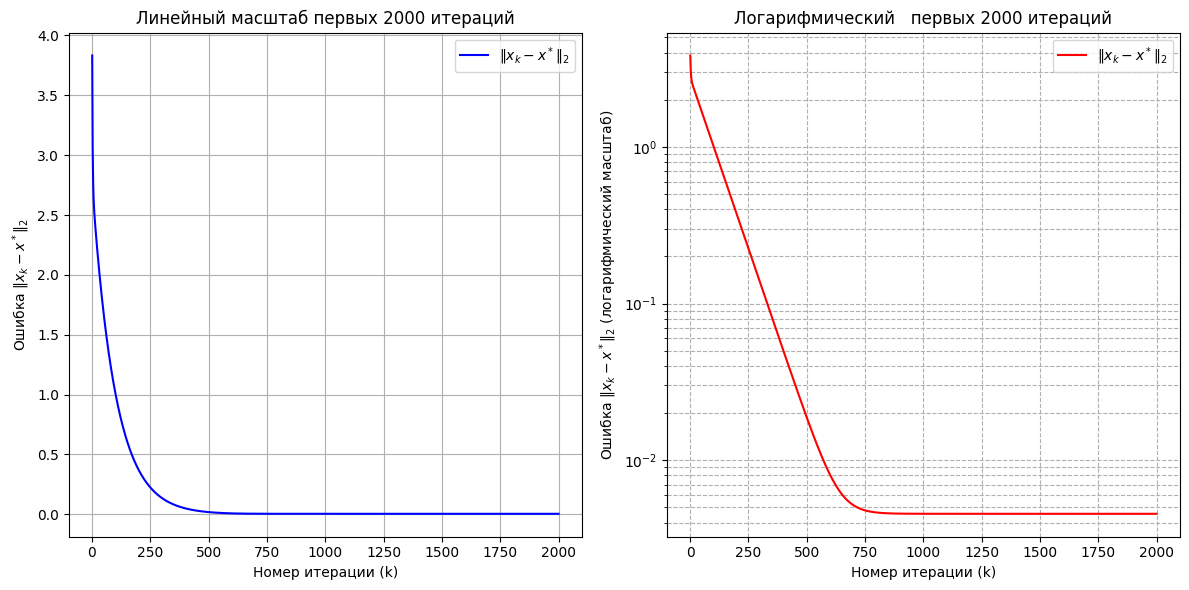

In [54]:
method = GDQuadraticFunctions(gamma, max_iter, x_0, A, b)
method.run()
logger = method.get_logger()

# Вычисление ошибок
errors = [np.linalg.norm(x_k - x_star) for x_k in logger]

# Построение графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# линейный масштаб
ax1.plot(range(1,2001), errors[0:2000], label=r'$\|x_k - x^*\|_2$', color='blue')
ax1.set_xlabel('Номер итерации (k)')
ax1.set_ylabel(r'Ошибка $\|x_k - x^*\|_2$')
ax1.set_title('Линейный масштаб первых 2000 итераций')
ax1.grid(True)
ax1.legend()

# логарифмический масштаб по оси Y
ax2.plot(range(1, 2001), errors[0:2000], label=r'$\|x_k - x^*\|_2$', color='red')
ax2.set_yscale('log')
ax2.set_xlabel('Номер итерации (k)')
ax2.set_ylabel(r'Ошибка $\|x_k - x^*\|_2$ (логарифмический масштаб)')
ax2.set_title('Логарифмический   первых 2000 итераций')
ax2.grid(True, which="both", ls="--")
ax2.legend()

plt.tight_layout()
plt.show()

__Вывод:__ Градиентный спуск с шагом  демонстрирует линейную сходимость для данной квадратичной задачи. Это видно из логарифмического графика, где функция ошибки убывает приблизительно линейно с ростом числа итераций k. Скорость сходимости относительно медленная из-за большого числа обусловленности $\kappa = ||A|| \cdot ||A^{-1}|| ≈ 377 $

__(е)__ Добавьте на график теоретическую сходимость, полученную на семинаре. Добавьте легенду, чтобы можно было отличить, какой график за что отвечает. Сделайте вывод.

Посчитаем значения ошибки при итерации GD по формуле нижней оценки на семинаре $||x_{k + 1} -x^*||^2 \leq (1 - \frac{\mu}{ L})||x_{k} -x^*||^2$

In [62]:
error_theor = [0 for _ in range(max_iter)]
error_theor[0] = np.linalg.norm(x_0 - x_star)
for i in range(1, max_iter):
  error_theor[i] = ((1 - mu / L) * error_theor[i-1]**2)**0.5

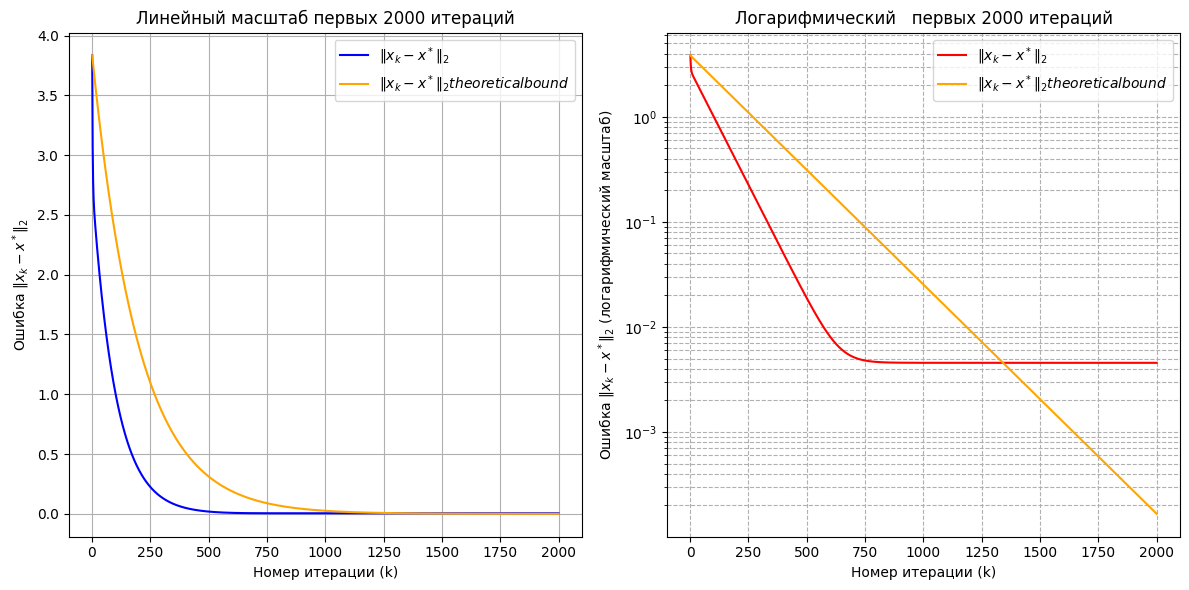

In [64]:
# Построение графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# линейный масштаб
ax1.plot(range(1,2001), errors[0:2000], label=r'$\|x_k - x^*\|_2$', color='blue')
ax1.plot(range(1,2001), error_theor[0:2000], label=r'$\|x_k - x^*\|_2 theoretical bound$', color='orange')
ax1.set_xlabel('Номер итерации (k)')
ax1.set_ylabel(r'Ошибка $\|x_k - x^*\|_2$')
ax1.set_title('Линейный масштаб первых 2000 итераций')
ax1.grid(True)
ax1.legend()

# логарифмический масштаб по оси Y
ax2.plot(range(1, 2001), errors[0:2000], label=r'$\|x_k - x^*\|_2$', color='red')
ax2.plot(range(1,2001), error_theor[0:2000], label=r'$\|x_k - x^*\|_2 theoretical bound$', color='orange')
ax2.set_yscale('log')
ax2.set_xlabel('Номер итерации (k)')
ax2.set_ylabel(r'Ошибка $\|x_k - x^*\|_2$ (логарифмический масштаб)')
ax2.set_title('Логарифмический   первых 2000 итераций')
ax2.grid(True, which="both", ls="--")
ax2.legend()

plt.tight_layout()
plt.show()

 Фактическая ошибка (синяя и красная линии) уменьшается быстрее, чем предсказывает теоретическая оценка (оранжевая линия). Это связано с тем, что теоретическая оценка описывает наихудший случай, тогда как конкретная структура матрицы ( A ) и выбор начальной точки могут ускорять сходимость.
 Обе кривые в логарифмическом масштабе представляют собой прямые линии, что подтверждает линейную скорость сходимости градиентного спуска для сильно выпуклых функций. График подтверждает корректность реализации градиентного спуска и демонстрирует, что метод эффективен даже при консервативной теоретической оценке. Теоретическая ошибка в пределе стремится к нулю, но так как точность вычислений на компьютере не абсолютна, то на практике точность вычисислений не стремится к нулю из-за ошибки вычислений на компьютере.





__(ж)__ Попробуйте метод с разными шагами (но постоянными в одном запуске) $\gamma_k = \gamma$. Уменьшайте и увеличивайте шаг. Нанесите все новые запуски на график (теоретическую сходимость можно убрать).

<ipython-input-5-becc8198700f>:25: RuntimeWarning: invalid value encountered in subtract
  self.x_current = self.x_current - self.gamma * grad


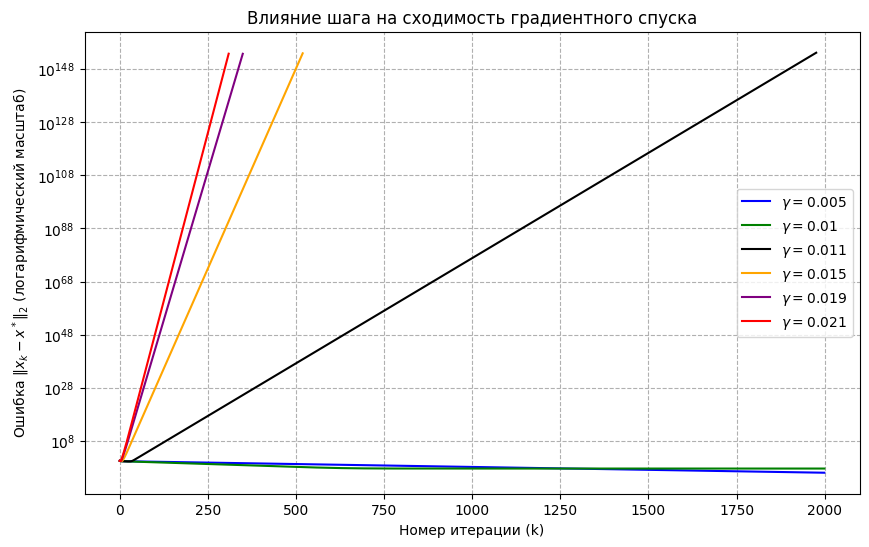

In [72]:
gammas = [0.005, 0.01, 0.011, 0.015, 0.019, 0.021]
colors = ['blue', 'green', 'black', 'orange', 'purple', 'red']

# Построение графика
plt.figure(figsize=(10, 6))
for gamma, color in zip(gammas, colors):
    method = GDQuadraticFunctions(gamma, max_iter, x_0, A, b)
    method.run()
    logs = method.get_logger()
    errors = [np.linalg.norm(x_k - x_star) for x_k in logs]
    label = f'$\\gamma = {gamma}$'
    plt.plot(range(2000), errors[:2000], label=label, color=color)

plt.yscale('log')
plt.xlabel('Номер итерации (k)')
plt.ylabel('Ошибка $\|x_k - x^*\|_2$ (логарифмический масштаб)')
plt.title('Влияние шага на сходимость градиентного спуска')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

__Вывод:__ При значении шага выше 1/L наблюдается расходиомость невязки

__(з)$^*$__ Исследуйте другие техники подбора шага, озвученные на семинаре:

1) Уменьшающийся с номером итерации шаг,

2) Наискорейший спуск: $\gamma_k = \arg\min_{\gamma} f(x_k - \gamma \nabla f(x_k))$,

3) Шаг Поляка-Шора: $\gamma_k = \tfrac{f(x^k) - f(x^*)}{\alpha \|\nabla f(x^k)\|^2}$, где $\alpha \geq 1$.

Учтите, что правило Поляка-Шора требует подбора дополнительного параметра эвристически (поиграйте с этим параметром отдельно и выберете какой подходит лучше). Советую для каждого подхода реализовать свой класс. Например, для пункта 1) нужно будет добавить scheduler, так как шаг теперь будет меняться в зависимости от итерации. Для пункта 2) необходимо как дополнительный метод в классе реализовать метод одномерной оптимизации (например, метод бисекции или золотого сечения). В пункте 3) можно обойтись без вышеперечисленных приколов :)

In [99]:
print(A)
print(np.linalg.eigvals(A))
print(b)

[[ 70.60730611  19.17581242 -11.63551335  -4.05098739  28.77819197
   13.78727223  -4.46500339  11.32207552  -4.96621785  15.3980846 ]
 [ 19.17581242 132.75637729  -1.37516954 -15.98223982  11.04947202
   10.36337914 -52.26911535 -36.46422227 -25.42001693  -7.11885798]
 [-11.63551335  -1.37516954 101.67735599   1.97783497  -0.70641993
    4.90259121 -33.29783299   6.72995891  51.95553785 -17.23830839]
 [ -4.05098739 -15.98223982   1.97783497  93.74721815  -0.80400011
   27.643583     4.57803846  -2.50944197  -4.54296517 -16.93027097]
 [ 28.77819197  11.04947202  -0.70641993  -0.80400011  44.90083026
  -38.80154362  14.1736181   -2.03960477  -2.00041483 -11.98502803]
 [ 13.78727223  10.36337914   4.90259121  27.643583   -38.80154362
   97.12737327  -1.10946754  -2.04448335   0.82120021   9.70519688]
 [ -4.46500339 -52.26911535 -33.29783299   4.57803846  14.1736181
   -1.10946754 106.99523334 -17.3874946    6.71137332   2.88645593]
 [ 11.32207552 -36.46422227   6.72995891  -2.50944197  -

In [133]:
class GD_DecreasingStep():
    def __init__(self, max_iter, x0, A, b):
        self.max_iter = max_iter
        self.x = x0.copy()
        self.errors = []
        self.x_star = np.linalg.solve(A, b)
        self.A = A
        self.b = b

    def compute_grad(self):
        return 0.5 * (np.dot(self.A +  self.A.T,  self.x)) - self.b

    def step(self, k):
        gamma_k = 1 / (k + 33)  # Scheduler для шага (начнем с 33)
        grad = self.compute_grad()
        self.x = self.x - gamma_k * grad

    def run(self):
        for k in range(self.max_iter):
            self.step(k)
            error = np.linalg.norm(self.x - x_star)
            self.errors.append(error)

# Запуск
max_iter = 10000
x0 = np.zeros(d)
gd_decreasing = GD_DecreasingStep(max_iter, x0, A, b)
gd_decreasing.run()
errors_decreasing = gd_decreasing.errors

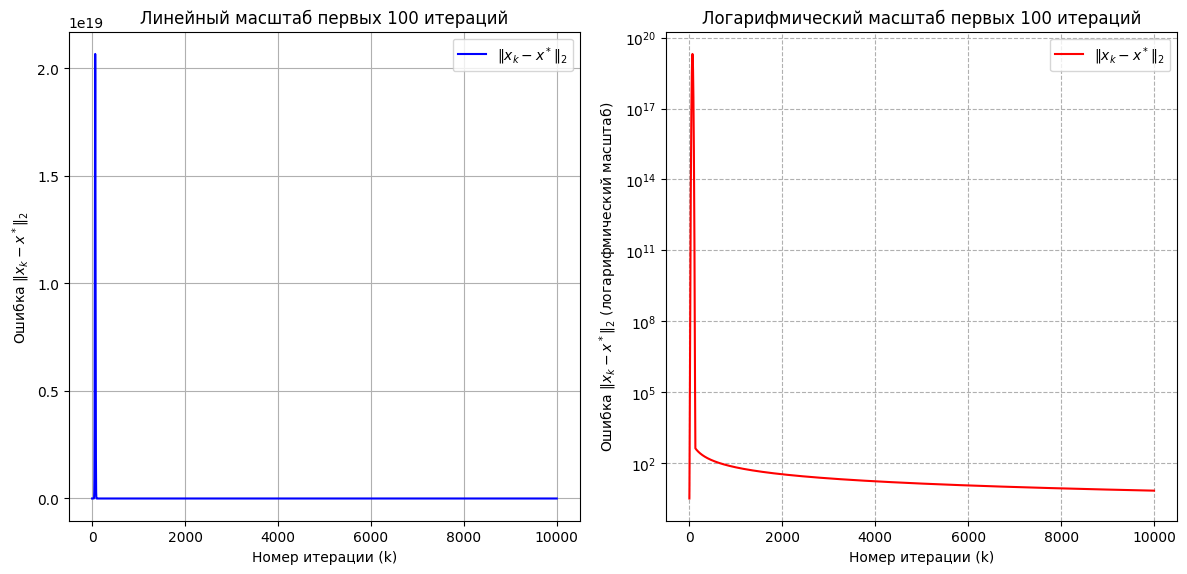

In [134]:
# Построение графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# линейный масштаб
ax1.plot(range(1,10001), errors_decreasing[0:10000], label=r'$\|x_k - x^*\|_2$', color='blue')
ax1.set_xlabel('Номер итерации (k)')
ax1.set_ylabel(r'Ошибка $\|x_k - x^*\|_2$')
ax1.set_title('Линейный масштаб первых 100 итераций')
ax1.grid(True)
ax1.legend()

# логарифмический масштаб по оси Y
ax2.plot(range(1, 10001), errors_decreasing[0:10000], label=r'$\|x_k - x^*\|_2$', color='red')
ax2.set_yscale('log')
ax2.set_xlabel('Номер итерации (k)')
ax2.set_ylabel(r'Ошибка $\|x_k - x^*\|_2$ (логарифмический масштаб)')
ax2.set_title('Логарифмический масштаб первых 100 итераций')
ax2.grid(True, which="both", ls="--")
ax2.legend()

plt.tight_layout()
plt.show()

__(и)$^*$__ Докажите сходимость градиентного спуска с константным шагом $\gamma$ со следующими предположениями:

1) $f(x)$ - $L$-гладкая функция.

2) Выполнено условие Поляка-Лоясиевича: $\|\nabla f(x)\|^2 \geq 2\mu \left(f(x) - f(x^*)\right)$.

Предвещая все вопросы, а что должно получиться, и как нам это делать, оставляю подсказки.

$\bullet$ Необходимо начать анализ градиентного спуска как в **невыпуклом** случае.

$\bullet$ Получив $f(x_{k+1}) \leq f(x_k) - \frac{1}{2L}\|\nabla f(x_k)\|^2$, необходимо вычесть из обеих частей $f(x^*)$ и воспользоваться условием 2 чтобы оценить $-\|\ldots\|^2$ сверху.

$\bullet$ В итоге вы должны получить $f(x_{k+1}) - f(x^*) \leq \left(1 - \frac{\mu}{L} \right)^{k+1} (f(x_0) - f(x^*))$.


Рассмотрим градиентный спуск с константным шагом \( \gamma = \frac{1}{L} \). Докажем его сходимость при условиях \( L \)-гладкости функции \( f(x) \) и выполнения условия Поляка-Лоясиевича.

Из \( L \)-гладкости следует:
$$
f(x_{k+1}) \leq f(x_k) + \nabla f(x_k)^T (x_{k+1} - x_k) + \frac{L}{2} \| x_{k+1} - x_k \|^2.
$$
Так как $ x_{k+1} = x_k - \frac{1}{L} \nabla f(x_k) $, то:
$$
f(x_{k+1}) \leq f(x_k) - \frac{1}{L} \| \nabla f(x_k) \|^2 + \frac{1}{2L} \| \nabla f(x_k) \|^2 = f(x_k) - \frac{1}{2L} \| \nabla f(x_k) \|^2.
$$ (получали это на семинаре)
По условию П-Л $\| \nabla f(x_k) \|^2 \geq 2 \mu (f(x_k) - f(x^*))$.
Подставляем:
$$
f(x_{k+1}) \leq f(x_k) - \frac{\mu}{L} (f(x_k) - f(x^*)).
$$
Вычитаем $ f(x^*) $:
$$
f(x_{k+1}) - f(x^*) \leq \left( 1 - \frac{\mu}{L} \right) (f(x_k) - f(x^*)).
$$
Наконец реккурентно
$$
f(x_{k+1}) - f(x^*) \leq \left( 1 - \frac{\mu}{L} \right)^{k+1} (f(x_0) - f(x^*)).
$$
Это демонстрирует линейную сходимость метода.

# Ускоренный градиентный спуск

Рассмотрим задачу минимизации эмпирического риска (это краеугольная задача машинного обучения):
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2.
\end{equation}

Будем рассматривать ленейную модель $g(w, x) = w^T x$ и логистическую/сигмоидную функцию потерь $l(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Такую задачу еще называют логистической регрессией.

__(а)__ Выпишите градиент и гессиан функции. Является ли задача выпуклой? Сильно-выпуклой? Оцените $L$ и $\mu$ для данной функции.

Градиент функции потерь $L(w)$ по $w$ вычисляется следующим образом:
\begin{equation}
\nabla L(w) = \frac{1}{n} \sum_{i=1}^n \frac{-y_i x_i}{1 + \exp(y_i w^T x_i)} + \lambda w
\end{equation}


Гессиан функции потерь $L(w)$ по $w$ вычисляем через дифференцивание градиента:
\begin{equation}
\nabla^2 L(w) = \frac{1}{n} \sum_{i=1}^n \frac{x_i x_i^T \exp(y_i w^T x_i)}{(1 + \exp(y_i w^T x_i))^2} + \lambda I
\end{equation}
где $I$ - единичная матрица.
 Функция потерь L(w) является выпуклой, так как гессиан $\nabla^2 L(w)$ является положительно полуопределенным, она также является $\mu-$сильно выпуклой с $\mu = \lambda$. Функция $\frac{\exp(y_i w^T x_i)}{(1 + \exp(y_i w^T x_i))^2}$ принимает максимальное значение при наименьшем значении аргумента, то есть максимальное значение равно $\frac{1}{4}$, а $\nabla^2 L(w) \leq \frac{1}{4n} \sum_{i=1}^n x_i x_i^T + \lambda I = \frac{1}{4n} XX^T + \lambda I$. Так как $||XX^T|| \leq \sqrt{n} \max_i{||x_i||} = \sqrt{n} R $, то $L =\frac{1}{4}R^2 + \lambda $


__(б)__ К заданию приложен датасет _mushrooms_. С помощью следующего кода сформируйте матрицу $X$ и вектор $y$ ($X$ - матрицу из векторов $\{x_i\}$ и вектор $y$ - из $\{y_i\}$):

In [215]:
dataset = "mushrooms.txt"
#файл должен лежать в той же директории, что и notebook
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), np.sign(data[1] - 1.5)
n, d = X.shape

In [216]:
y

array([-1.,  1.,  1., ...,  1., -1.,  1.])

Разделите случайно данные (а значит $X$ и $y$) на две части: обучающую и тестовую (примерно в отношении $4$ к $1$). Опишите, как это было сделано.

In [217]:
from sklearn.model_selection import train_test_split  # пользовались этим на курсе введения в АД (код взял прямо оттуда)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Обучающая выборка: {X_train.shape[0]} объектов, Тестовая выборка: {X_test.shape[0]} объектов")

Обучающая выборка: 6499 объектов, Тестовая выборка: 1625 объектов


__(в)__ Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$ по формулам полученным выше. Решите задачу оптимизации/обучите модель машинного обучения с помощью градиентного спуска, реализованного Вами выше (если не делали задания со звездой, то нужно вставить формулу аналитического подсчета градиента). Изобразите график сходимости. Какой критерий сходимости будет использовать? Сделайте вывод.

In [218]:
# Максимальная норма объектов
R = np.max(np.linalg.norm(X_train, axis=1))
print(f"Максимальная норма объекта: R = {R}")
# Оценка L с lambda = 1

lambda_reg = 1.0
L = (1 / 4) * R**2 + lambda_reg
print(f"Константа Липшица: L = {L}")

Максимальная норма объекта: R = 4.58257569495584
Константа Липшица: L = 6.25


In [260]:
from functools import partial
# Функция потерь (логистическая с регуляризацией)
def logistic_loss(w, X, y, lambda_reg):
    z = y * (X @ w)
    return jnp.mean(jnp.log(1 + jnp.exp(-z))) + (lambda_reg / 2) * jnp.sum(w**2)

# Запуск градиентного спуска
gamma = 1 / L
max_iter = 1000
w_0 = jnp.zeros(X.shape[1])
func2 = partial(logistic_loss, X=X_train, y=y_train, lambda_reg=lambda_reg)
method = GD(gamma, max_iter, w_0, func2)
method.run()
logger = method.get_logger()

<ipython-input-184-77949cbe77d0>:6: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX


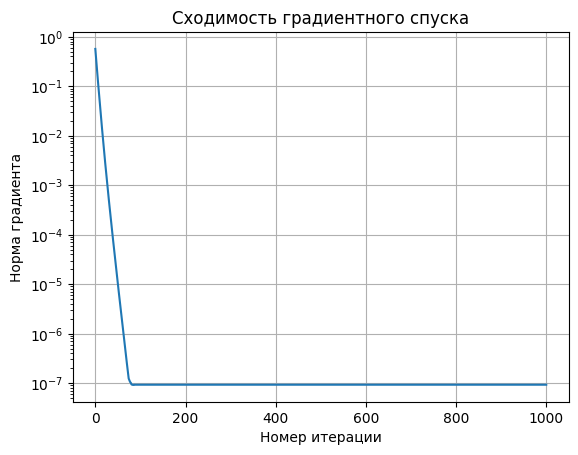

In [261]:
# График сходимости
errors = [jnp.linalg.norm(jax.grad(func2)(w)) for w in logger]
plt.plot(errors, label='Градиентный спуск')
plt.yscale('log')
plt.xlabel('Номер итерации')
plt.ylabel('Норма градиента')
plt.title('Сходимость градиентного спуска')
plt.grid(True)
plt.show()

__Вывод:__ График в логарифмическом масштабе показывает линейное убывание нормы градиента, что указывает на линейную сходимость градиентного спуска для выпуклой задачи. В качестве критерия сходимости стоит использовать сравнение нормы градиента с некоторым $\varepsilon$



__(г)__ Как использовать итоговую модель для предсказания? Ответив на вопрос, сделайте предсказания на тестовой выборке. Сравните с реальными метками. Количество правильно угаданных меток есть точность/accuracy вашей модели. Запустите еще раз процесс обучения из пункта в), постройте как меняется точность модели от номера итерации градиентного спуска (измеряйте не каждую итерацию, а, например, каждую 100 или 1000). Сделайте вывод.

Ответ: Для предсказания вычисляем $y_i = sign(w_{opt}^T x_i)$

In [262]:
w_opt = method.x_current
def predict(w, X):
    return jnp.sign(X @ w)
y_pred = predict(w_opt, X_test)

In [263]:
accuracy = np.mean(y_pred == y_test)
print(f"Точность модели: {accuracy * 100:.2f}%")

Точность модели: 88.62%


88.61538


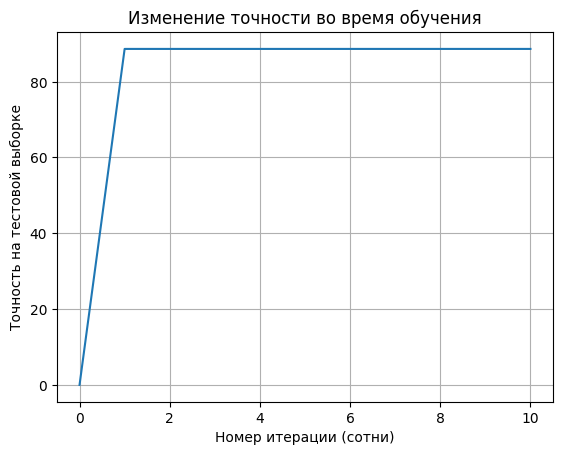

In [264]:
accuracies = np.array([np.mean(predict(w, X_test) == y_test) * 100 for w in logger[0::100]])
print(accuracies[2])
# График изменения точности
plt.plot(accuracies[0:100])
plt.xlabel('Номер итерации (сотни)')
plt.ylabel('Точность на тестовой выборке')
plt.title('Изменение точности во время обучения')
plt.grid(True)
plt.show()

__(д)__ Реализуйте метод тяжелого шарика и метод Нестерова. Если Вам будет так удобнее, то можно как реализовать отдельный класс под метод, либо создать класс Optimizer и от него наследовать все методы оптимизации (на ваш вкус и цвет)

In [235]:
class HeavyBall(GD):
    def __init__(self, gamma, beta, max_iter, x_start, func):
        super().__init__(gamma, max_iter, x_start, func)
        self.beta = beta
        self.v = jnp.zeros_like(x_start)

    def step(self):
        grad = self.compute_grad()
        self.v = self.beta * self.v - self.gamma * grad
        self.x_current = self.x_current + self.v

In [276]:
class Nesterov(GD):
    def __init__(self, gamma, beta, max_iter, x_start, func, is_adaptive):
        super().__init__(gamma, max_iter, x_start, func)
        self.beta = beta
        self.v = jnp.zeros_like(x_start)
        self.is_adaptive = is_adaptive
        self.k = 0

    def adaptive_step(self): #понадобится при адаптивном выборе шага
        beta_k = self.beta(self.k)
        grad = jax.grad(self.func)(self.x_current + beta_k * self.v)
        self.v = beta_k * self.v - self.gamma * grad
        self.x_current = self.x_current + self.v
        self.k += 1

    def step(self):
        if self.is_adaptive:
          self.adaptive_step()
        else:
          grad = jax.grad(self.func)(self.x_current + self.beta * self.v)
          self.v = self.beta * self.v - self.gamma * grad
          self.x_current = self.x_current + self.v

__(е)__ Решите задачу логистической регрессии с помощью метода тяжелого шарика. Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Постройте график сходимости метода от числа итераций для различных значений моментума. Всегда ли сходимость является монотонной?

In [246]:
betas = [-1, -0.5, -0.1, 0.1, 0.5, 0.7, 1]
loss_histories_hb = {}
max_iter = 1000
x_start = jnp.zeros(X_train.shape[1])

for beta in betas:
    hb = HeavyBall(gamma, beta, max_iter, x_start, func2)
    hb.run()
    logger = hb.get_logger()
    loss_histories_hb[beta] = [func2(w) for w in hb.logger]

<ipython-input-184-77949cbe77d0>:6: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX


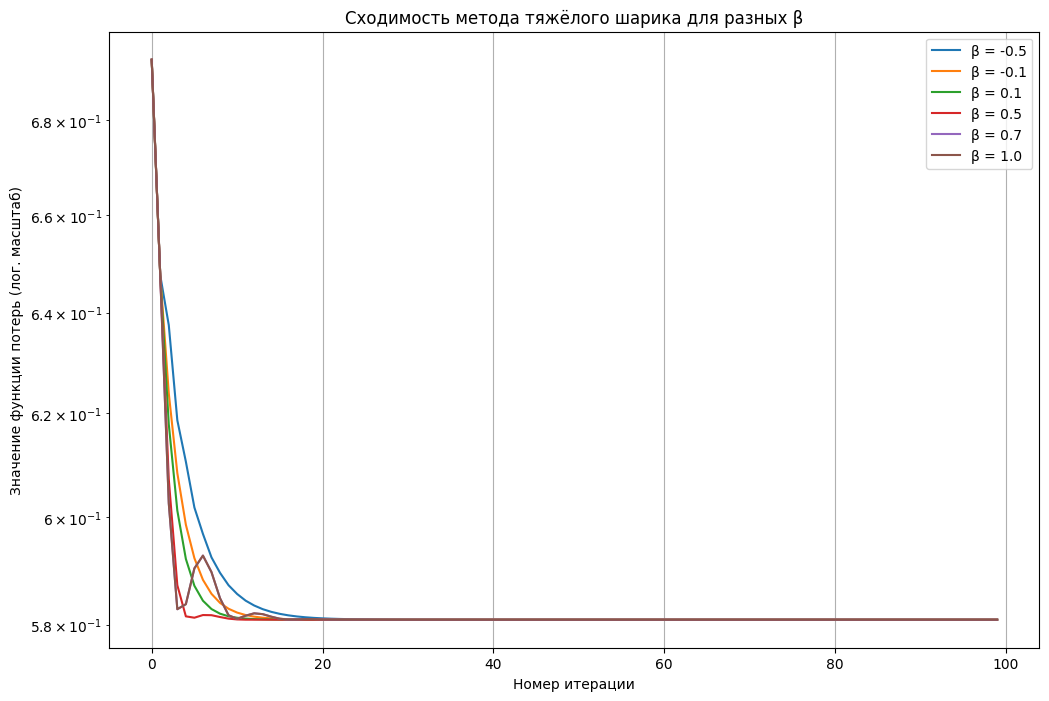

In [255]:
plt.figure(figsize=(12, 8))
for beta, losses in loss_histories_hb.items():
    if beta == -1:
      continue
    plt.plot(losses[:100], label=f'β = {beta:.1f}')
plt.yscale('log')
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции потерь (лог. масштаб)')
plt.title('Сходимость метода тяжёлого шарика для разных β')
plt.legend()
plt.grid(True)
plt.show()

__Вывод:__ Сходимость метода тяжёлого шарика не всегда монотонна. При больших положительных $\beta$
 (например, 0.5, 0.7 или 1.0) инерция может вызывать колебания функции потерь, что приводит к немонотонному поведению. При отрицательных $\beta$
 сходимость может быть медленной или вовсе отсутствовать. (на графике не стал изображать $\beta = -1$ так как там метод не сходится и данные лишь портят масштаб)

__(ж)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте на этот же график сходимость градиентного спуска с шагом $\frac{1}{L}$. Сделайте вывод.

Быстрее всего сошелся метод с большим $\beta$. Чтобы показать нестабильность и скорость сходимости, проведем эксперимент с  $\beta = 0.999$

Если читать задачу буквально, и предполагать, что под временем работы указано не количество итераций, а реальное время, то напишем для измепрения отдельную функцию

<ipython-input-184-77949cbe77d0>:6: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX


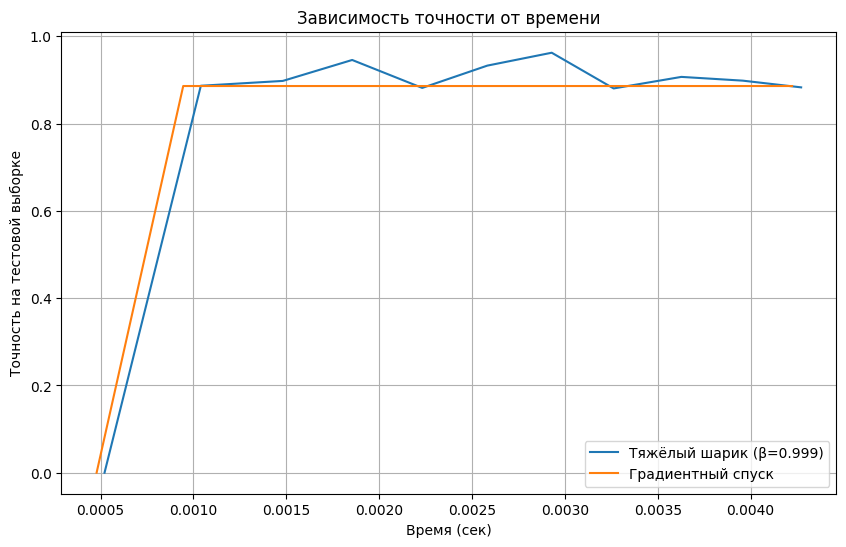

In [293]:
import time
def measure_accuracy_over_time(method, X_test, y_test, func, intervals=100):
    accuracies = []
    times = []
    start_time = time.time()
    for i in range(0, max_iter + 1, intervals):
        w = method.logger[i]
        y_pred = jnp.sign(X_test @ w)
        acc = jnp.mean(y_pred == y_test)
        accuracies.append(acc)
        times.append(time.time() - start_time)
    return times, accuracies

# Тяжёлый шарик с лучшим beta
best_beta = 0.999
hb_best = HeavyBall(gamma, best_beta, max_iter, x_start, func2)
hb_best.run()
times_hb, acc_hb = measure_accuracy_over_time(hb_best, X_test, y_test, func2)

# Градиентный спуск
gd = GD(gamma, max_iter, x_start, func2)
gd.run()
times_gd, acc_gd = measure_accuracy_over_time(gd, X_test, y_test, func2)

# График
plt.figure(figsize=(10, 6))
plt.plot(times_hb, acc_hb, label='Тяжёлый шарик (β=0.999)')
plt.plot(times_gd, acc_gd, label='Градиентный спуск')
plt.xlabel('Время (сек)')
plt.ylabel('Точность на тестовой выборке')
plt.title('Зависимость точности от времени')
plt.legend()
plt.grid(True)
plt.show()

__Вывод:__ Метод тяжёлого шарика с $\beta = 0.999$
 достигает высокой точности не быстрее, чем градиентный спуск (возможно из-за особенности реализации), благодаря ускорению за счёт инерции. Градиентный спуск сходится медленнее, но более стабильно.

__(и)__ Решите задачу логистической регресии с помощью метода Нестерова. Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Проверьте также значения моментума равные $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ - номер итерации), а если решаете сильно выпуклую задачу, то и $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$. Постройте график сходимости метода от числа итераций для различных значений моментума. Всегда ли сходимость является монотонной?

__Решение__: В очередной раз перепишем то что уже 5 раз писали чтобы

In [278]:
# Адаптивные схемы
beta_funcs = {
    'k/(k+3)': lambda k: k / (k + 3) if k > 0 else 0,
    'k/(k+2)': lambda k: k / (k + 2) if k > 0 else 0,
    'k/(k+1)': lambda k: k / (k + 1) if k > 0 else 0
}

# Запуск
loss_histories_nesterov = {}
betas = [-1, -0.5, -0.1, 0, 0.1, 0.5, 0.7, 1]
for beta in betas:
    nag = Nesterov(gamma, beta, max_iter, x_start, func2, is_adaptive=False)
    nag.run()
    loss_histories_nesterov[beta] = [func2(w) for w in nag.logger]


<ipython-input-184-77949cbe77d0>:6: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX


In [279]:
for name, beta_func in beta_funcs.items():
    nag_adapt = Nesterov(gamma, beta_func, max_iter, x_start, func2, is_adaptive=True)
    nag_adapt.run()
    loss_histories_nesterov[name] = [func2(w) for w in nag_adapt.logger]

<ipython-input-184-77949cbe77d0>:6: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX


In [281]:
loss_histories_nesterov.keys()

dict_keys([-1, -0.5, -0.1, 0, 0.1, 0.5, 0.7, 1, 'k/(k+3)', 'k/(k+2)', 'k/(k+1)'])

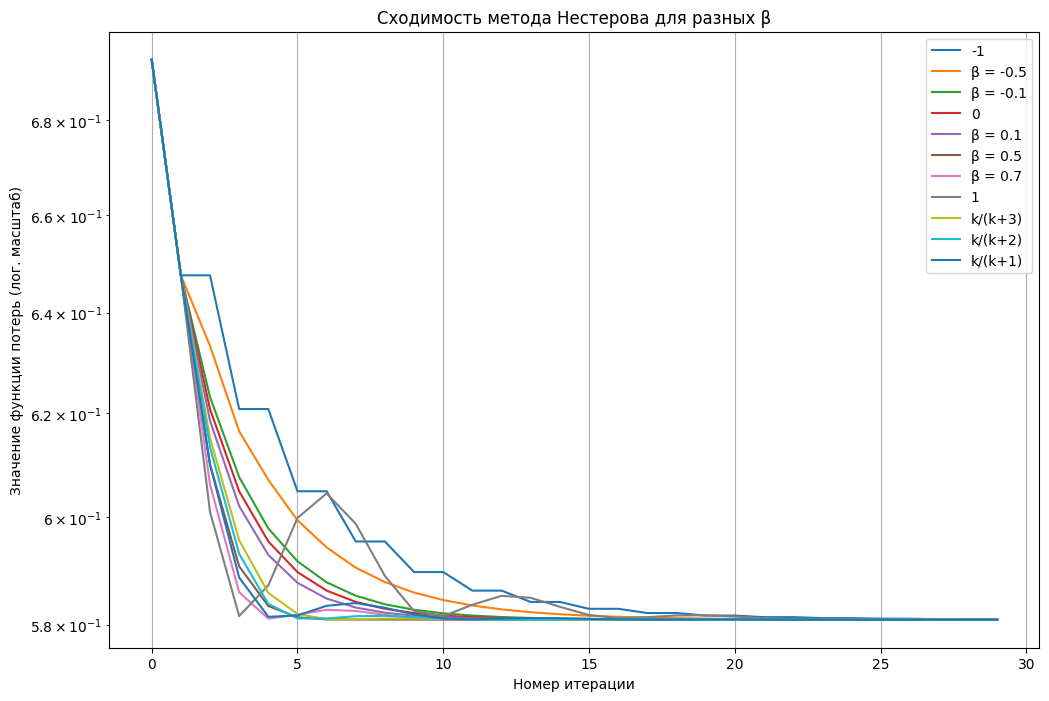

In [284]:
plt.figure(figsize=(12, 8))
for key, losses in loss_histories_nesterov.items():
    label = f'β = {key:.1f}' if isinstance(key, float) else key
    plt.plot(losses[0:30], label=label)
plt.yscale('log')
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции потерь (лог. масштаб)')
plt.title('Сходимость метода Нестерова для разных β')
plt.legend()
plt.grid(True)
plt.show()

__Вывод:__ сходимость не всегда является монотонной, при больших значениях наблюдаются колебания. Адаптивные схемыобеспечивают более стабильное уменьшение потерь.



__(к)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте этот график к графикам для тяжелого шарика и градиентного спуска из пункта. Сделайте итоговый вывод.

In [ ]:
best_beta = 0.999

<ipython-input-184-77949cbe77d0>:6: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX


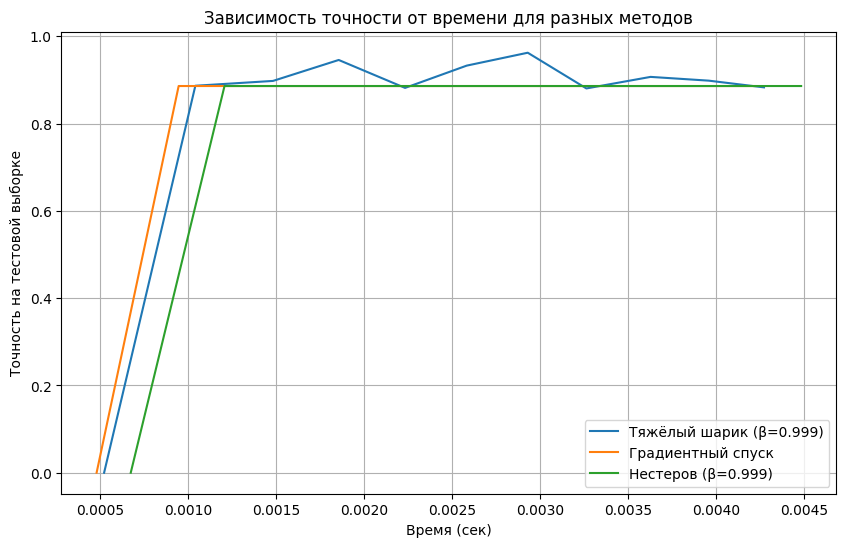

In [295]:
nag_best = Nesterov(gamma, best_beta, max_iter, x_start, func2, is_adaptive=False)
nag_best.run()
times_nag, acc_nag = measure_accuracy_over_time(nag_best, X_test, y_test, func)

# График
plt.figure(figsize=(10, 6))
plt.plot(times_hb, acc_hb, label='Тяжёлый шарик (β=0.999)')
plt.plot(times_gd, acc_gd, label='Градиентный спуск')
plt.plot(times_nag, acc_nag, label='Нестеров (β=0.999)')
plt.xlabel('Время (сек)')
plt.ylabel('Точность на тестовой выборке')
plt.title('Зависимость точности от времени для разных методов')
plt.legend()
plt.grid(True)
plt.show()

__Вывод__: Вообще странно, что реаизация градиентного спуска получилась самой быстрой из трех. Возможно есть проблема с выводом данных, или с реализацией ускоренных методов. Даже по наклону видно, что GD - самый быстрый, что очевидно не должно соответтвовать действительности. Я предполагаю, что это либо ошибка в функции измерения времени, или неэффективная реализация ускоренных методов

# Нижние оценки

__(л)$^*$__ Реализуйте функцию, которую мы рассматривали на семинаре для построения нижних оценок. Важно:

1) Если вы хотите запустить метод на $K$ итераций, то и в вашей функции размернось будет зависеть от $K$.

2) Необходимо найти аналитическое значение $\Delta$.

Постройте на графике одновременно линию, отражающую нижнюю оценку, а также линию сходимости метода Нестерова (в нижних оценках можно опустить числовую константу). Это значит, что по оси $x$ у вас отложено $K$ -- количество итераций, а по оси $y$ -- точность, которую вы достигли после этих $K$ шагов. Более того, для каждого $K$ у вас будет своя функция.

Для этого вы заранее должны реализовать функцию в зависимости от $L, \mu, K$. Градиент для метода можно использовать аналитический. В качестве критерия нужно использовать $\|x_K - x^*\|^2$. Сделайте вывод.

In [ ]:
#ответ